In [8]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
    !git clone https://github.com/mikessut/glider_sim
    from glider_sim.glider_model import *
else:
    from glider_model import *
import numpy as np
from ipywidgets import interactive, FloatSlider
import matplotlib.pyplot as plt

# $C_L$

Text(0, 0.5, '$C_L$')

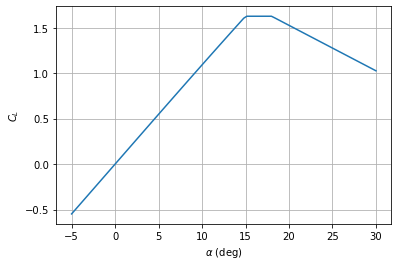

In [2]:
alpha = np.linspace(-5*np.pi/180, 30*np.pi/180, 100)
g = GliderPitchSim()
plt.plot(alpha*180/np.pi, g.Clift(alpha))
plt.grid(True)
plt.xlabel(r'$\alpha$ (deg)')
plt.ylabel(r'$C_L$')

# $C_d$

Text(0, 0.5, '$C_d$')

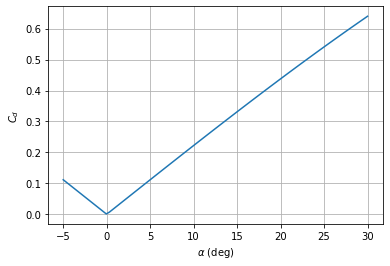

In [3]:
alpha = np.linspace(-5*np.pi/180, 30*np.pi/180, 100)
g = GliderPitchSim()
plt.plot(alpha*180/np.pi, g.Cdrag(alpha))
plt.grid(True)
plt.xlabel(r'$\alpha$ (deg)')
plt.ylabel(r'$C_d$')

In [17]:
def run_sim(wing_pos):    
    glider = GliderPitchSim()
    glider._wing_alpha = 0 * np.pi / 180
    glider._horz_stab_alpha = -5.5 * np.pi / 180
    #glider._pos_wing = 2e-2
    glider._pos_wing = wing_pos
    #glider._pos_horz_stab = 30e-2
    # glider._horz_stab_A = 7e-2 * 7e-2
    # glider._wing_A = 120e-2 * 7e-2
    glider._wing_A = 60e-2 * 7e-2
    #glider._mass = 15e-3
    #glider._momI *= .05  # This dampens the response

    # Specify initial velocity and pitch angle
    glider.init_conditions((4.5, 0), 9*np.pi/180)
    for _ in range(2000):
        glider.step()
    glider.finalize_lists()
    glider.plot()
    print("glide ratio:", -glider._r[-1][0] / glider._r[-1][1])
    print("final speed:", np.linalg.norm(glider._v[-1]))
    return glider

In [18]:
interactive_plot = interactive(run_sim, wing_pos=FloatSlider(min=-2e-2, max=2e-2, step=1e-3, continuous_update=False,  readout_format='.4f'))
interactive_plot

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='wing_pos', max=0.02, min=-0…

Plot total energy to make sure we aren't making a perpetual motion machine...

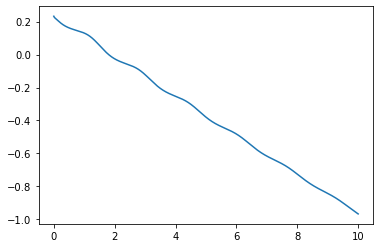

In [21]:
glider = GliderPitchSim()
glider.init_conditions((4.5, 0), 9*np.pi/180)
for _ in range(2000):
    glider.step()
glider.finalize_lists()
plt.plot(glider._t, .5*glider._mass*np.linalg.norm(glider._v, axis=1)**2 + glider._mass * G * glider._r[:, 1])

# Moment vs. $\alpha$

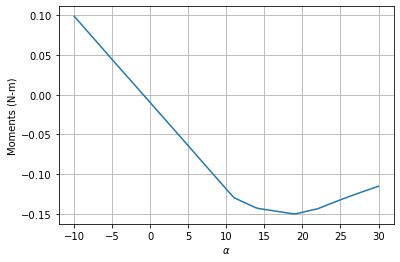

In [22]:
aoas = np.linspace(-10*np.pi/180, 30*np.pi/180, 100)
vmag = 4
glider._pos_wing = 15e-2

moments = np.zeros((len(aoas),))
center_lift = np.zeros((len(aoas),))
stab_alpha = np.zeros((len(aoas),))
Fwing_all = np.zeros((len(aoas),))
Fstab_all = np.zeros((len(aoas),))

for n, aoa in enumerate(aoas):
    Flift_wing = glider.Clift(aoa + glider._wing_alpha) * glider._wing_A * .5 * RHO_AIR * vmag**2
    Fdrag_wing = glider.Cdrag(aoa + glider._wing_alpha) * glider._wing_A * .5 * RHO_AIR * vmag**2
    # Rotate into body frame (rotate by AoA) (longitudinal axis, vert axis)
    Fwing = (rotM(-aoa) @ np.vstack((-Fdrag_wing, Flift_wing))).flatten()
    
    Flift_horz_stab = glider.Clift(aoa + glider._horz_stab_alpha) * glider._horz_stab_A * .5 * RHO_AIR * vmag**2
    Fdrag_horz_stab = glider.Cdrag(aoa + glider._horz_stab_alpha) * glider._horz_stab_A * .5 * RHO_AIR * vmag**2

    Fstab = (rotM(-aoa) @ np.vstack((-Fdrag_horz_stab, Flift_horz_stab))).flatten()
    
    moments[n] = -(Fwing[1] * glider._pos_wing + Fstab[1] * glider._pos_horz_stab)
    center_lift[n] = moments[n] / -(Fwing[1] + Fstab[1])
    stab_alpha[n] = aoa + glider._horz_stab_alpha
    Fwing_all[n] = Fwing[1]
    Fstab_all[n] = Fstab[1]

plt.plot(aoas*180/np.pi, moments)
plt.xlabel(r'$\alpha$')
plt.ylabel('Moments (N-m)')
plt.grid(True)


Text(0.5, 0, 'Elevator angle')

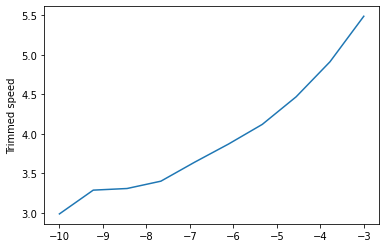

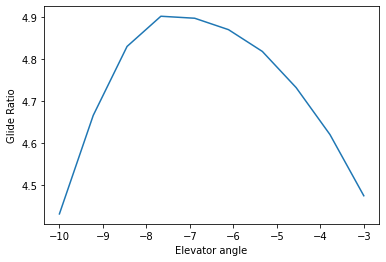

In [24]:
trims = np.linspace(-3, -10, 10)
glide = np.zeros((10, ))
speed = np.zeros((10, ))
for n, elev_trim in enumerate(trims):
    glider = GliderPitchSim()
    glider._wing_alpha = 0 * np.pi / 180
    glider._horz_stab_alpha = elev_trim * np.pi / 180
    glider._pos_wing = 1e-2
    #glider._pos_horz_stab = 30e-2
    # glider._horz_stab_A = 7e-2 * 7e-2
    # glider._wing_A = 120e-2 * 7e-2
    # glider._mass = 15e-3
    # glider._wing_A = 60e-2 * 7e-2
    #glider._momI *= 4

    # Specify initial velocity and pitch angle
    glider.init_conditions((4.5, 0), 9*np.pi/180)
    for _ in range(2000):
        glider.step()
    glider.finalize_lists()
    glide[n] = -glider._r[-1][0] / glider._r[-1][1]
    speed[n] = np.linalg.norm(glider._v[-1])
    
plt.plot(trims, speed)
plt.ylabel('Trimmed speed')

plt.figure()
plt.plot(trims, glide)
plt.ylabel('Glide Ratio')
plt.xlabel('Elevator angle')